<a href="https://colab.research.google.com/github/alaa-shehab/Mind_Controlled_Prosthetic_Arm/blob/main/Copy_of_Graduation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Graduation_Project/grasp-and-lift-eeg-detection.zip /content

In [3]:
!unzip /content/grasp-and-lift-eeg-detection.zip -d dataset

Archive:  /content/grasp-and-lift-eeg-detection.zip
  inflating: dataset/sample_submission.csv.zip  
  inflating: dataset/test.zip        
  inflating: dataset/train.zip       


In [4]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

CUDA-enabled GPU found. Training should be faster.


In [6]:
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import copy

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Kaggle Dataset

In [9]:
import zipfile
with zipfile.ZipFile("/content/dataset/test.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("/content/dataset/train.zip","r") as z:
    z.extractall(".")

In [1]:
import pandas as pd
from glob import glob

In [2]:
test = []

for i in range(1, 13):
  fnames =  sorted(glob('test/subj%d_series*_data.csv' % (i)))
  for f in fnames:
    data = pd.read_csv(f).drop(['id' ], axis=1)
    test.append(data)

KeyboardInterrupt: ignored

In [86]:
X_testing = np.asarray(pd.concat(test).astype(float))

In [2]:
raw = []
# y_raw = []
hs_raw = []
for i in range(1, 13):
  fnames =  sorted(glob('train/subj%d_series*_data.csv' % (i)))
  for f in fnames:
    data = pd.read_csv(f).drop(['id' ], axis=1)
    events_fname = f.replace('_data','_events')
    labels = pd.read_csv(events_fname).drop(['id' ], axis=1)
    cols_remove=labels.columns.tolist()[2:5]
    df =labels.loc[:, ~labels.columns.isin(cols_remove)]
    # col1_rem = labels.columns.tolist()[0]
    # df = labels.loc[:, ~labels.columns.isin(col1_rem)]
    hs = df.drop(['HandStart'], axis=1)
    raw.append(data)
    # y_raw.append(df)
    hs_raw.append(hs)

In [3]:
import numpy as np
X = np.asarray(pd.concat(raw).astype(float))
y = np.asarray(pd.concat(hs_raw).astype(float))

In [4]:
del raw
# del y_raw
del hs_raw

## Preprocessing

In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from math import pi
import pywt
import scipy

In [6]:
def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [7]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [8]:
filtered = wavelet_denoising(X, wavelet='db2', level=3)

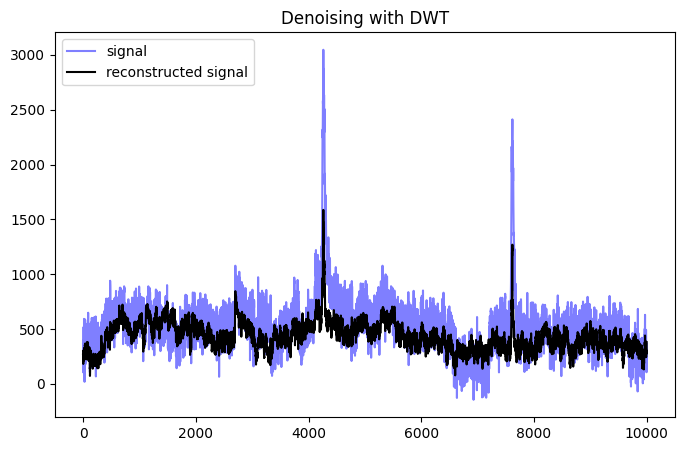

In [ ]:
ig, ax = plt.subplots(figsize=(8,5))
ax.plot(X[:10000,1], label='signal', color="b", alpha=0.5,)
ax.plot(filtered[:10000,1], label='reconstructed signal',color="k")
ax.legend(loc='upper left')
ax.set_title('Denoising with DWT')
plt.show()

In [9]:
# Strandard
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_standard_fil = scaler.fit_transform(filtered)
# X_standard = scaler.fit_transform(X)

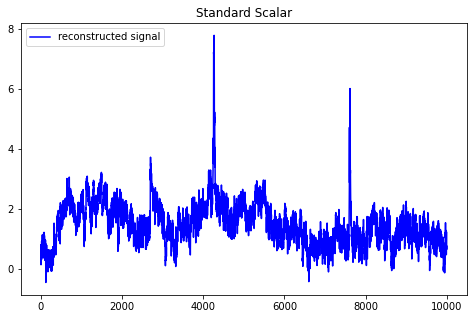

In [ ]:
ig, ax = plt.subplots(figsize=(8,5))
# ax.plot(filtered[:10000,1], label='signal', color="b", alpha=0.5,)
ax.plot(X_standard_fil[:10000,1],label='reconstructed signal', color='blue')
ax.legend(loc='upper left')
ax.set_title('Standard Scalar')
plt.show()

In [10]:
del X

In [11]:
del filtered

## Feature Extraction

In [12]:
# PCA
from sklearn.decomposition import FastICA, PCA
pca = PCA()
X_pca = pca.fit_transform(X_standard_fil)

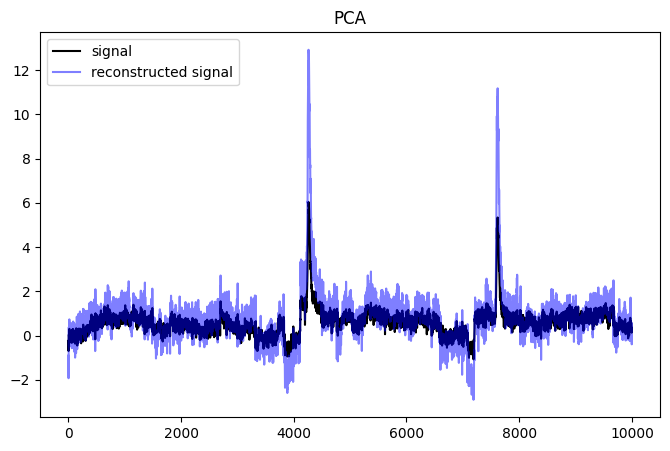

In [ ]:
ig, ax = plt.subplots(figsize=(8,5))
ax.plot(X_standard_fil[:10000,1], label='signal', color='black')
ax.plot(X_pca[:10000,1],label='reconstructed signal', color="b", alpha=0.5,)
ax.legend(loc='upper left')
ax.set_title('PCA')
plt.show()

In [22]:
import matplotlib.pyplot as plt
plt.scatter(X[:,1], X[:,2])
plt.show()

NameError: ignored

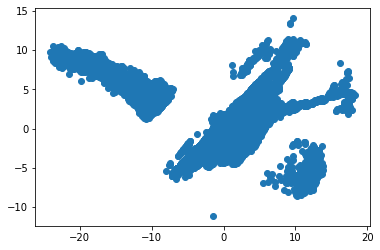

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_standard_fil[:,1], X_standard_fil[:,2])
plt.show()

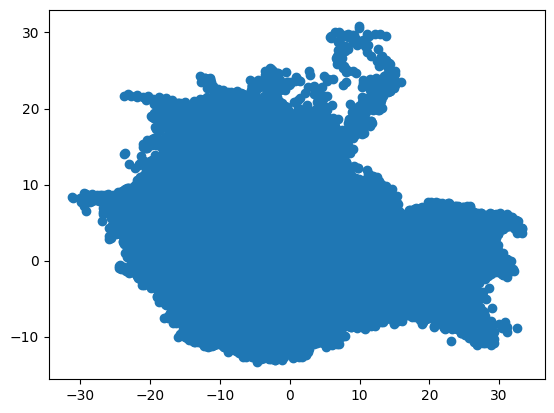

In [15]:
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


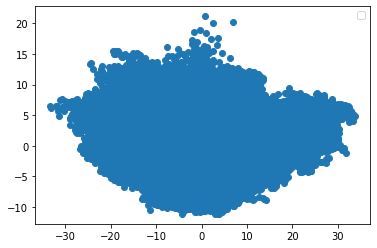

In [ ]:
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list({'HandStart', 'Grasp', 'Release'}))
plt.show()

In [13]:
del X_standard_fil

In [ ]:
# ICA
from sklearn.decomposition import FastICA, PCA
ica = FastICA(n_components=6, random_state=0, whiten='unit-variance')
# X_ica = ica.fit_transform(X_standard_fil)
X_pca_ica = ica.fit_transform(X_pca)


In [ ]:
ig, ax = plt.subplots(figsize=(8,5))
# ax.plot(X_standard_fil[:10000,1], label='signal', color='black')
ax.plot(X_pca_ica[:10000,1],label='reconstructed signal', color="b", alpha=0.5,)
ax.legend(loc='upper left')
ax.set_title('ICA')
plt.show()

## Split Data

In [34]:
from sklearn.model_selection import train_test_split

In [14]:
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

def split_data(X, y):
  for train_index, test_index in kf.split(X):
      X_train, test_x = X[train_index], X[test_index]
      Y_train, test_y = y[train_index], y[test_index]

  return X_train, Y_train, test_x,test_y

In [15]:
X_train, Y_train, X_test, Y_test = split_data(X_pca, y)

In [ ]:
X_train.shape

(11990503, 32)

In [ ]:
Y_train.shape

(9904530, 6)

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(X_standard_fil,y,test_size=0.25,random_state=42)

In [15]:
X_train,X_test,Y_train,Y_test=train_test_split(X_pca,y,test_size=0.25,random_state=42)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


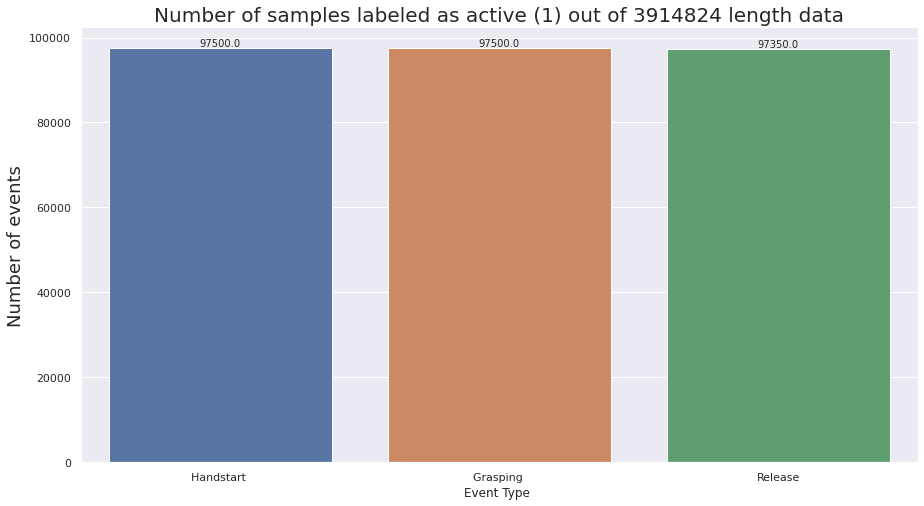

In [ ]:
import seaborn as sns
ye=pd.DataFrame(Y_train_pca)

ye.columns=["Handstart ","Grasping ","Release"]
categories = list(ye.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, ye.iloc[:,0:].sum().values)
plt.title("Number of samples labeled as active (1) out of {0} length data".format((ye.shape[0])),fontsize=20)

plt.ylabel('Number of events', fontsize=18)
plt.xlabel('Event Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = ye.iloc[:,0:].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

## Logistic Regression Model




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate

y_pred = np.empty((len(X_Valid), 6))

for i in range(6):
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train.argmax(axis=1))
    y_pred[:,i] = clf.predict_proba(X_Valid)[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9741970769864348


In [ ]:
# Use score method to get accuracy of model
score = log_model.score(test_x.values, test_y.values.argmax(axis=1))
print(score)

In [ ]:
from sklearn import metrics
predictions = clf.predict(test_x.values)
cm = metrics.confusion_matrix(test_y.values.argmax(axis=1), predictions)
print(cm)

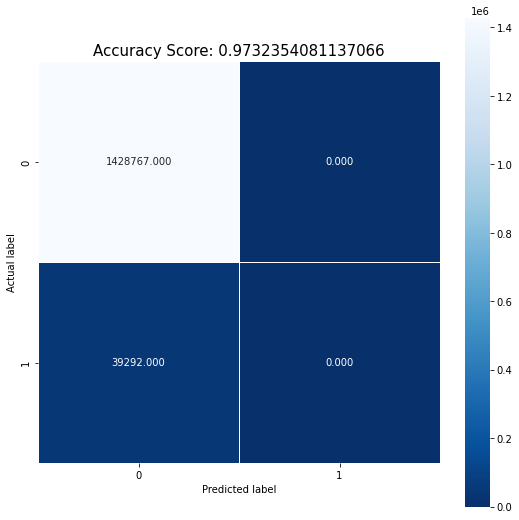

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
temp = np.array(y_pred).reshape(len(y_pred),2)
prediction_df = pd.DataFrame(temp)
m = np.zeros_like(prediction_df.values)
m[np.arange(len(prediction_df)), prediction_df.values.argmax(1)] = 1

prediction_df = pd.DataFrame(m, columns = prediction_df.columns).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
events=['FirstDigitTouch','BothReleased']
for i in range(2):
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(Y_Valid.iloc[:,i].values,prediction_df.iloc[:,i].values)
  print('Accuracy for %s: %f' %(events[i],accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(Y_Valid.iloc[:,i].values,prediction_df.iloc[:,i].values)
  print('precision for %s: %f' %(events[i],precision))
  # recall: tp / (tp + fn)
  recall = recall_score(Y_Valid.iloc[:,i].values,prediction_df.iloc[:,i].values)
  print('recall for %s: %f' %(events[i],recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(Y_Valid.iloc[:,i].values,prediction_df.iloc[:,i].values)
  print('f1_score for %s: %f' %(events[i],f1))
  print('\n')

Accuracy for FirstDigitTouch: 0.026461
precision for FirstDigitTouch: 0.026461
recall for FirstDigitTouch: 1.000000
f1_score for FirstDigitTouch: 0.051558


Accuracy for BothReleased: 0.973472


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision for BothReleased: 0.000000
recall for BothReleased: 0.000000
f1_score for BothReleased: 0.000000




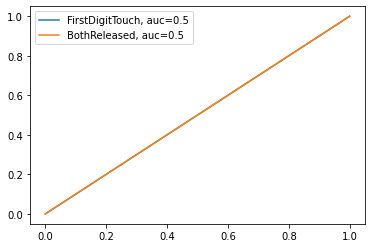

In [ ]:
plt.figure(0).clf()
for i in range(2):
  fpr, tpr, thresh = metrics.roc_curve(Y_Valid.iloc[:,i].values,prediction_df.iloc[:,i].values)
  auc = metrics.roc_auc_score(Y_Valid.iloc[:,i].values,prediction_df.iloc[:,i].values)
  plt.plot(fpr,tpr,label=str(events[i])+", auc="+str(round(auc,3)))
plt.legend(loc=0)

## Model

### Model with Dense Layers

In [18]:
del X_pca

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf
load = 1
time_steps = 1000
subsample = 50
model = Sequential()
model.add(Dense(32, input_shape=(time_steps//subsample, 32,1), activation='relu'))
# model.add(keras.layers.Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='relu'))
# model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='sigmoid'))



adam = Adam(lr = 0.001)

model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ['accuracy','mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20, 32, 32)        64        
                                                                 
 dense_1 (Dense)             (None, 20, 32, 16)        528       
                                                                 
 dense_2 (Dense)             (None, 20, 32, 12)        204       
                                                                 
 dense_3 (Dense)             (None, 20, 32, 6)         78        
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 11523     
                                                                 
Total params: 12,397
Trainable params: 12,397
Non-traina

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


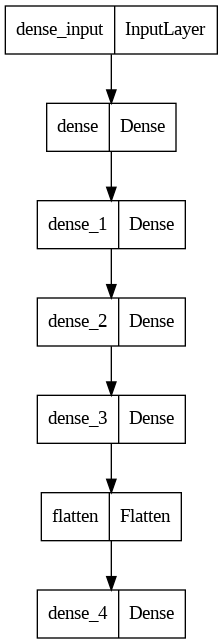

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [176]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM, BatchNormalization, Conv1D, Conv2D, Flatten, MaxPooling2D, MaxPooling1D,Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, TimeDistributed, ConvLSTM2D
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf
time_steps = 1000
subsample= 50

cnn_model = Sequential()
cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01, 0.001)))
cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01, 0.001)))
cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(128, (7, 7), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01, 0.001)))
cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
# cnn_model.add(Dense(32, activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(12, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01, 0.001)))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2, activation='sigmoid'))



adam = Adam(learning_rate = 0.001)
learning_rate = 0.1
epochs = 50
momentum = 0.8

decay_rate = learning_rate / epochs
ada = keras.optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=decay_rate)
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

cnn_model.compile(optimizer = ada, loss = "binary_crossentropy", metrics = ['accuracy','mse'])

# cnn_model.summary()

In [77]:
time_steps = 1000
subsample = 10
model3 = Sequential()
model3.add(Conv1D(64, 5,  activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001)))
model3.add(BatchNormalization())
# model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.25))
model3.add(Conv1D(64, 7,  activation='relu',kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001)))
model3.add(BatchNormalization())
# model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.25))
model3.add(Bidirectional(LSTM(256,kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001),return_sequences = True)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(12, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(Dense(12, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001)))
model3.add(BatchNormalization())
# model3.add(Dropout(0.25))
model3.add(Dense(2, activation='sigmoid'))

rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model3.compile(loss='binary_crossentropy', optimizer= ada, metrics=['accuracy'])
# model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [54]:
time_steps = 1000
subsample = 10
model2 = Sequential()
model2.add(Conv1D(256, 7, input_shape = (time_steps//subsample, 32),  activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.25))
model2.add(Conv1D(256, 5,  activation='relu',kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add((LSTM(256,kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.01),return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(12, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(12, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='sigmoid'))

rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model2.compile(loss='binary_crossentropy', optimizer= ada, metrics=['accuracy'])
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 94, 256)           57600     
                                                                 
 batch_normalization_89 (Bat  (None, 94, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 47, 256)          0         
 g1D)                                                            
                                                                 
 dropout_68 (Dropout)        (None, 47, 256)           0         
                                                                 
 conv1d_34 (Conv1D)          (None, 43, 256)           327936    
                                                                 
 batch_normalization_90 (Bat  (None, 43, 256)        

In [204]:
model1 = Sequential()
model1.add(TimeDistributed(Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001))))
model1.add(BatchNormalization())

model1.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001))))
model1.add(BatchNormalization())

model1.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001))))
model1.add(BatchNormalization())

model1.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001))))
model1.add(BatchNormalization())
model1.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model1.add(TimeDistributed(Flatten()))
model1.add(LSTM(512))

model1.add(Dense(12, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001)))
model1.add(Dense(2, activation='sigmoid'))

model1.compile(optimizer = ada, loss = "binary_crossentropy", metrics = ["accuracy"])

In [83]:
def generator_cnn(Xtr,y_data,batch_size):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(Xtr)-time_steps)
            x_time_data[i] = Xtr[random_index:random_index+time_steps:subsample]
            yy.append(y_data[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],-1,x_time_data.shape[1], x_time_data.shape[2])), yy

In [19]:
def generator_LSTM(batch_size, X_train, Y_train):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(X_train)-time_steps)
            x_time_data[i] = X_train[random_index:random_index+time_steps:subsample]
            yy.append(Y_train[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

In [20]:
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [56]:
def generator(batch_size, X_train, Y_train):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(X_train)-time_steps)
            x_time_data[i] = X_train[random_index:random_index+time_steps:subsample]
            yy.append(Y_train[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy

In [21]:
time_steps = 1000
subsample = 10
def val_generator_test_LSTM(test_x, test_y):
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(test_x)-time_steps)
            x_time_data[i] = test_x[random_index:random_index+time_steps:subsample]
            yy.append(test_y[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

In [21]:
time_steps = 1000
subsample = 50
def val_generator_test(test_x, test_y):
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(test_x)-time_steps)
            x_time_data[i] = test_x[random_index:random_index+time_steps:subsample]
            yy.append(test_y[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

In [89]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    # val_acc = history.history['val_accuracy']
    # val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    # plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    # plt.plot(epochs, val_loss, 'k', label='Validation loss ')
    plt.title('Training loss')
    plt.legend()

    plt.show()

Conv2D Model

In [186]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "conv2d_sgd/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_2d_sgd = cnn_model.fit(generator(128, X_train, Y_train), steps_per_epoch = 600, epochs=50,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/50
302/600 [==============>...............] - ETA: 19s - loss: 50.2743 - accuracy: 0.4941 - mse: 0.2140

KeyboardInterrupt: ignored

Conv1D + LSTM

In [205]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_conv1d_ada3/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_conv1d_ada3 = model1.fit(generator_cnn(X_train, Y_train, 64), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1994/2000 [============================>.] - ETA: 0s - loss: 4.3483 - accuracy: 0.8745
Epoch 1: saving model to lstm_conv1d_ada3/cp.ckpt
2000/2000 [==============================] - 16s 6ms/step - loss: 4.3473 - accuracy: 0.8747 - lr: 0.1000
Epoch 2/35
1996/2000 [============================>.] - ETA: 0s - loss: 3.7978 - accuracy: 0.9719
Epoch 2: saving model to lstm_conv1d_ada3/cp.ckpt
2000/2000 [==============================] - 13s 7ms/step - loss: 3.7974 - accuracy: 0.9720 - lr: 0.0998
Epoch 3/35
1998/2000 [============================>.] - ETA: 0s - loss: 3.4923 - accuracy: 0.9726
Epoch 3: saving model to lstm_conv1d_ada3/cp.ckpt
2000/2000 [==============================] - 13s 6ms/step - loss: 3.4921 - accuracy: 0.9726 - lr: 0.0996
Epoch 4/35
2000/2000 [==============================] - ETA: 0s - loss: 3.2614 - accuracy: 0.9734
Epoch 4: saving model to lstm_conv1d_ada3/cp.ckpt
2000/2000 [==============================] - 13s 7ms/step - loss: 3.2614 - accuracy: 0.9734 -

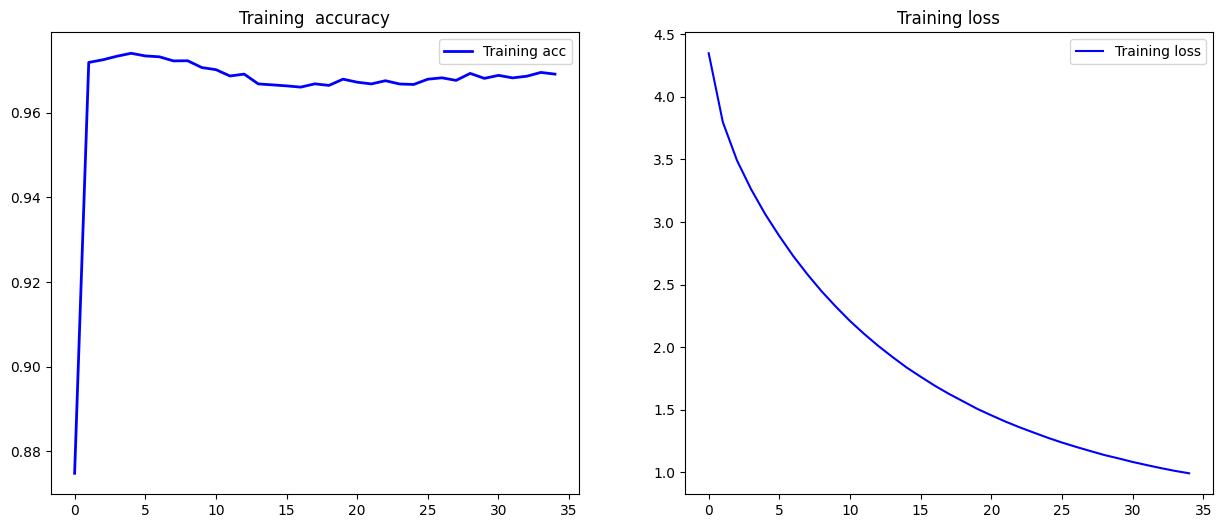

In [206]:
plot_training_history(history_lstm_conv1d_ada3)

In [208]:
np.mean(history_lstm_conv1d_ada3.history['accuracy'])

0.9664604936327253

In [209]:
from keras.models import model_from_json

model_lstm_ada_json = model1.to_json()

with open("model_lstm_conv1d_ada3.json", "w") as json_file:
    json_file.write(model_lstm_ada_json)

model1.save_weights("model_lstm_conv1d_ada3.h5")
print("Model saved")

Model saved


In [210]:
gen_data = val_generator_cnn(X_test,Y_test)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model1.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.5306


In [211]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 2))
y_test=np.zeros((num_test, 2))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model1.predict(x_test, verbose = 0)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/2)

roc_auc: 0.6741465544278124


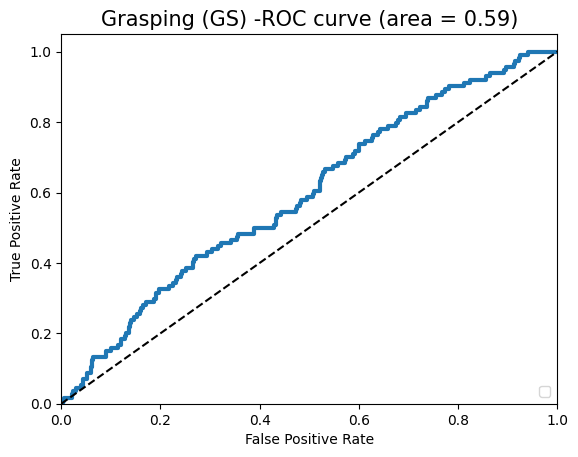

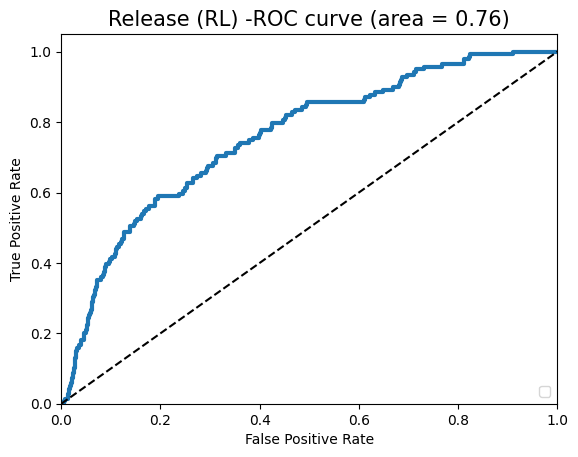

In [212]:
l=["Grasping (GS)","Release (RL)"]
for i in range(0,2):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

In [191]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_conv1d_ada2/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_conv1d_ada2 = model1.fit(generator_cnn(X_train, Y_train, 128), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1999/2000 [============================>.] - ETA: 0s - loss: 3.8360 - accuracy: 0.9717
Epoch 1: saving model to lstm_conv1d_ada2/cp.ckpt
2000/2000 [==============================] - 16s 7ms/step - loss: 3.8357 - accuracy: 0.9718 - lr: 0.1000
Epoch 2/35
1995/2000 [============================>.] - ETA: 0s - loss: 2.8802 - accuracy: 0.9740
Epoch 2: saving model to lstm_conv1d_ada2/cp.ckpt
2000/2000 [==============================] - 13s 7ms/step - loss: 2.8794 - accuracy: 0.9740 - lr: 0.0998
Epoch 3/35
1995/2000 [============================>.] - ETA: 0s - loss: 2.2708 - accuracy: 0.9735
Epoch 3: saving model to lstm_conv1d_ada2/cp.ckpt
2000/2000 [==============================] - 13s 7ms/step - loss: 2.2702 - accuracy: 0.9735 - lr: 0.0996
Epoch 4/35
2000/2000 [==============================] - ETA: 0s - loss: 1.7944 - accuracy: 0.9736
Epoch 4: saving model to lstm_conv1d_ada2/cp.ckpt
2000/2000 [==============================] - 13s 7ms/step - loss: 1.7944 - accuracy: 0.9736 -

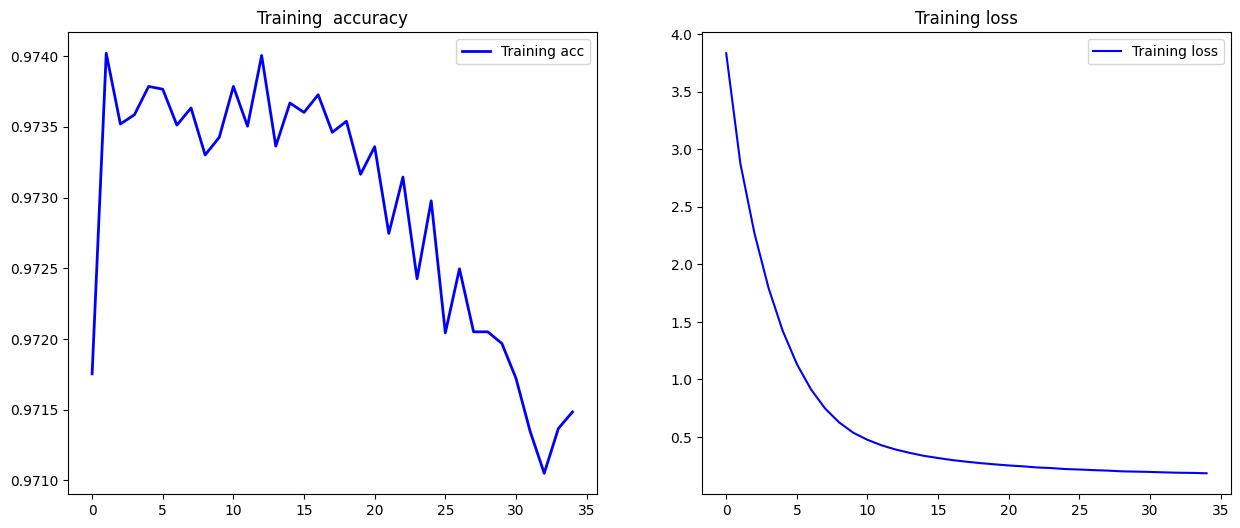

In [192]:
plot_training_history(history_lstm_conv1d_ada2)

In [193]:
np.mean(history_lstm_conv1d_ada2.history['accuracy'])

0.9729243278503418

In [197]:
from keras.models import model_from_json

model_lstm_ada_json = model1.to_json()

with open("model_lstm_conv1d_ada2.json", "w") as json_file:
    json_file.write(model_lstm_ada_json)

model1.save_weights("model_lstm_conv1d_ada2.h5")
print("Model saved")

Model saved


In [194]:
gen_data = val_generator_cnn(X_test,Y_test)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model1.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.5382


In [195]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 2))
y_test=np.zeros((num_test, 2))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model1.predict(x_test, verbose = 0)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/2)

roc_auc: 0.7395892840762275


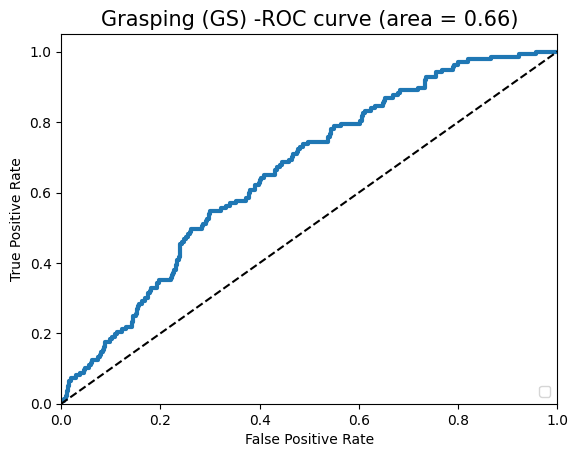

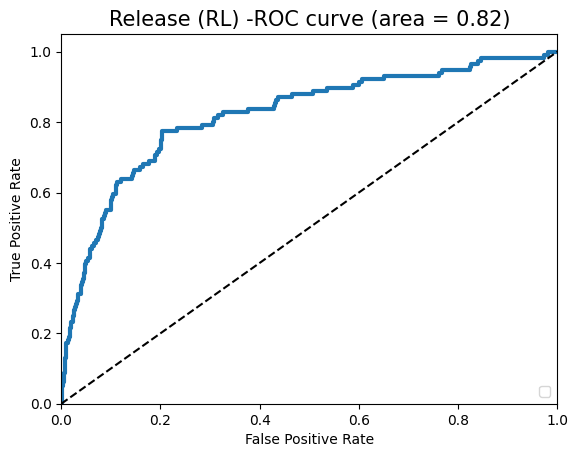

In [196]:
l=["Grasping (GS)","Release (RL)"]
for i in range(0,2):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

In [168]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_conv1d/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_conv1d = model1.fit(generator_cnn(X_train, Y_train, 128), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1559/2000 [======================>.......] - ETA: 2s - loss: 4.1425 - accuracy: 0.1443

KeyboardInterrupt: ignored

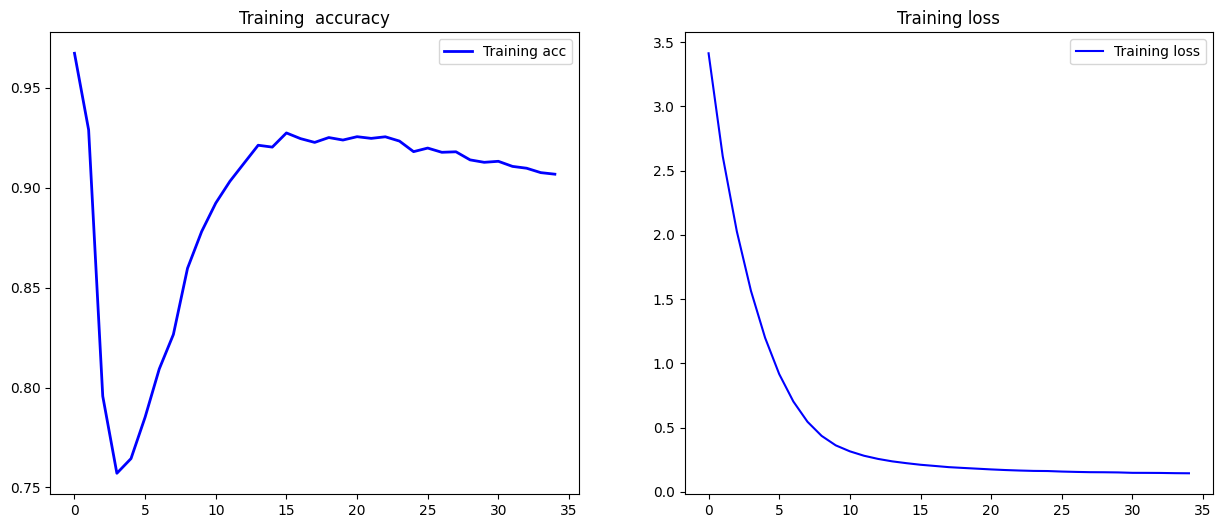

In [115]:
plot_training_history(history_lstm_conv1d)

In [117]:
np.mean(history_lstm_conv1d.history['accuracy'])

0.8940297978264945

In [118]:
from keras.models import model_from_json

model_lstm_ada_json = model1.to_json()

with open("model_lstm_conv1d_ada.json", "w") as json_file:
    json_file.write(model_lstm_ada_json)

model1.save_weights("model_lstm_conv1d_ada.h5")
print("Model saved")

Model saved


In [126]:
def val_generator_cnn(x_val, y_val_data):
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(x_val)-time_steps)
            x_time_data[i] = x_val[random_index:random_index+time_steps:subsample]
            yy.append(y_val_data[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],-1,x_time_data.shape[1], x_time_data.shape[2])), yy

In [128]:
gen_data = val_generator_cnn(X_test,Y_test)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model1.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.641


In [131]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 2))
y_test=np.zeros((num_test, 2))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model1.predict(x_test, verbose = 0)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/2)

roc_auc: 0.7734402419211845


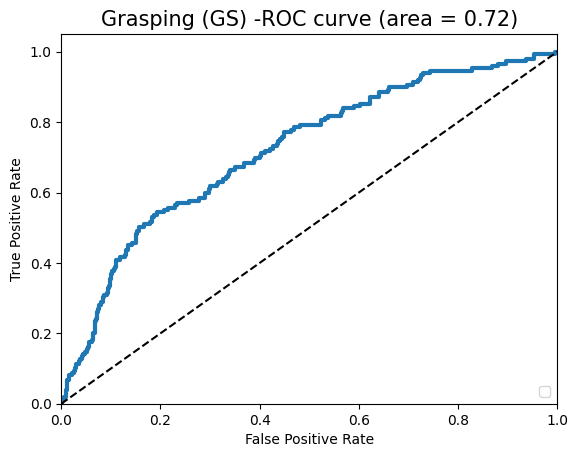

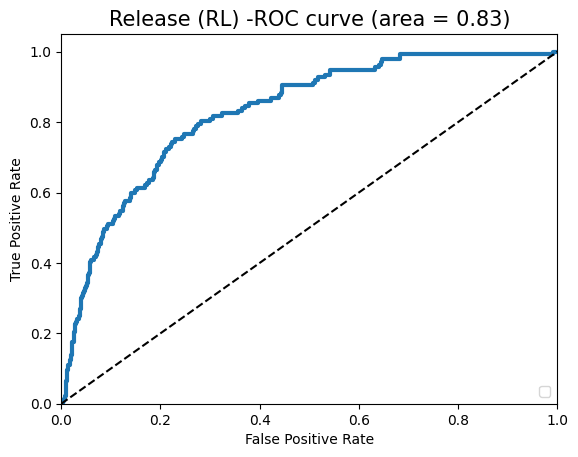

In [132]:
l=["Grasping (GS)","Release (RL)"]
for i in range(0,2):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

In [78]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_sgd2/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_sgd2 = model3.fit(generator_LSTM(128, X_train, Y_train), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1999/2000 [============================>.] - ETA: 0s - loss: 4.6206 - accuracy: 0.6398
Epoch 1: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 75s 35ms/step - loss: 4.6193 - accuracy: 0.6399 - lr: 0.1000
Epoch 2/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.9668 - accuracy: 0.7211
Epoch 2: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 69s 35ms/step - loss: 0.9664 - accuracy: 0.7211 - lr: 0.0998
Epoch 3/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.2241 - accuracy: 0.7358
Epoch 3: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 69s 35ms/step - loss: 0.2240 - accuracy: 0.7358 - lr: 0.0996
Epoch 4/35
2000/2000 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.6883
Epoch 4: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 70s 35ms/step - loss: 0.1630 - accuracy: 0.6883 - lr: 0.0994
Epoch 5/35
1

KeyboardInterrupt: ignored

In [33]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_sgd2/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_sgd2 = model2.fit(generator_LSTM(128, X_train, Y_train), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1999/2000 [============================>.] - ETA: 0s - loss: 23.2448 - accuracy: 0.5643
Epoch 1: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 66s 32ms/step - loss: 23.2433 - accuracy: 0.5643 - lr: 0.1000
Epoch 2/35
1999/2000 [============================>.] - ETA: 0s - loss: 17.7733 - accuracy: 0.5841
Epoch 2: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 64s 32ms/step - loss: 17.7721 - accuracy: 0.5841 - lr: 0.0998
Epoch 3/35
1999/2000 [============================>.] - ETA: 0s - loss: 13.6441 - accuracy: 0.5978
Epoch 3: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 64s 32ms/step - loss: 13.6432 - accuracy: 0.5978 - lr: 0.0996
Epoch 4/35
1999/2000 [============================>.] - ETA: 0s - loss: 10.4852 - accuracy: 0.6070
Epoch 4: saving model to lstm_sgd2/cp.ckpt
2000/2000 [==============================] - 64s 32ms/step - loss: 10.4845 - accuracy: 0.6071 - lr: 0.0994
Epoc

KeyboardInterrupt: ignored

In [78]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_ada/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_ada2 = model3.fit(generator_LSTM(256, X_train, Y_train), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1999/2000 [============================>.] - ETA: 0s - loss: 1.0174 - accuracy: 0.4601
Epoch 1: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 81s 38ms/step - loss: 1.0170 - accuracy: 0.4602 - lr: 0.1000
Epoch 2/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.6777
Epoch 2: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 76s 38ms/step - loss: 0.1534 - accuracy: 0.6778 - lr: 0.0998
Epoch 3/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.7604
Epoch 3: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 75s 38ms/step - loss: 0.1399 - accuracy: 0.7604 - lr: 0.0996
Epoch 4/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.7916
Epoch 4: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 75s 38ms/step - loss: 0.1340 - accuracy: 0.7916 - lr: 0.0994
Epoch 5/35
1999/

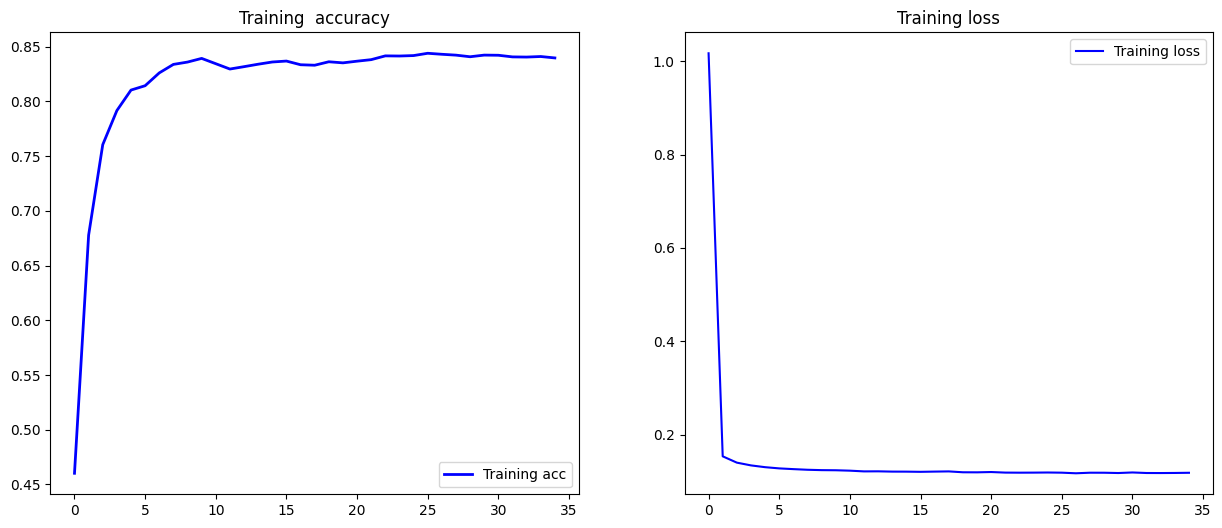

In [79]:
plot_training_history(history_lstm_ada2)

In [80]:
np.mean(history_lstm_ada2.history['accuracy'])

0.8173022278717585

In [81]:
from keras.models import model_from_json

model_lstm_ada_json = model3.to_json()

with open("model_lstm_ada2.json", "w") as json_file:
    json_file.write(model_lstm_ada_json)

model3.save_weights("model_lstm_ada2.h5")
print("Model saved")

Model saved


In [82]:
gen_data = val_generator_test_LSTM(X_test,Y_test)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model3.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.6438


In [83]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 2))
y_test=np.zeros((num_test, 2))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model3.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
roc_auc: 0.5007152173945673


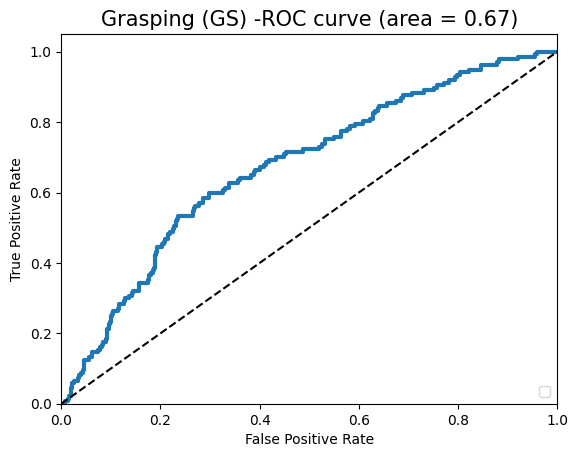

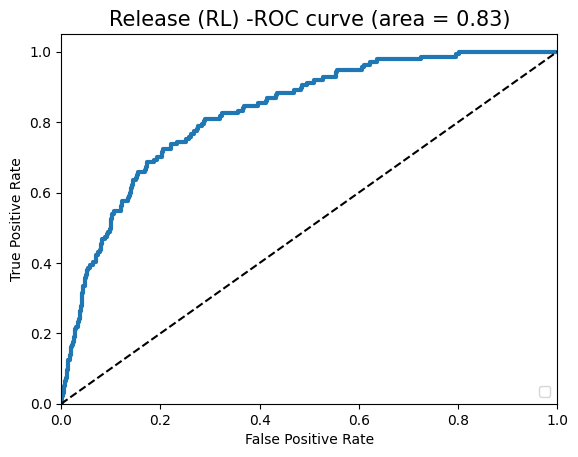

In [84]:
l=["Grasping (GS)","Release (RL)"]
for i in range(0,2):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

In [88]:
new_model = model3.load_weights('/content/model_lstm_ada2.h5')

AttributeError: ignored

In [ ]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path = "lstm_ada/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [loss_history, lr_rate, cp_callback]
history_lstm_ada = model3.fit(generator_LSTM(128, X_train, Y_train), steps_per_epoch = 2000, epochs= 35,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/35
1999/2000 [============================>.] - ETA: 0s - loss: 1.9875 - accuracy: 0.4351
Epoch 1: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 37s 16ms/step - loss: 1.9867 - accuracy: 0.4351 - lr: 0.1000
Epoch 2/35
1998/2000 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.4835
Epoch 2: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1507 - accuracy: 0.4835 - lr: 0.0998
Epoch 3/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.5561
Epoch 3: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1396 - accuracy: 0.5561 - lr: 0.0996
Epoch 4/35
1999/2000 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.6073
Epoch 4: saving model to lstm_ada/cp.ckpt
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1354 - accuracy: 0.6073 - lr: 0.0994
Epoch 5/35
2000/

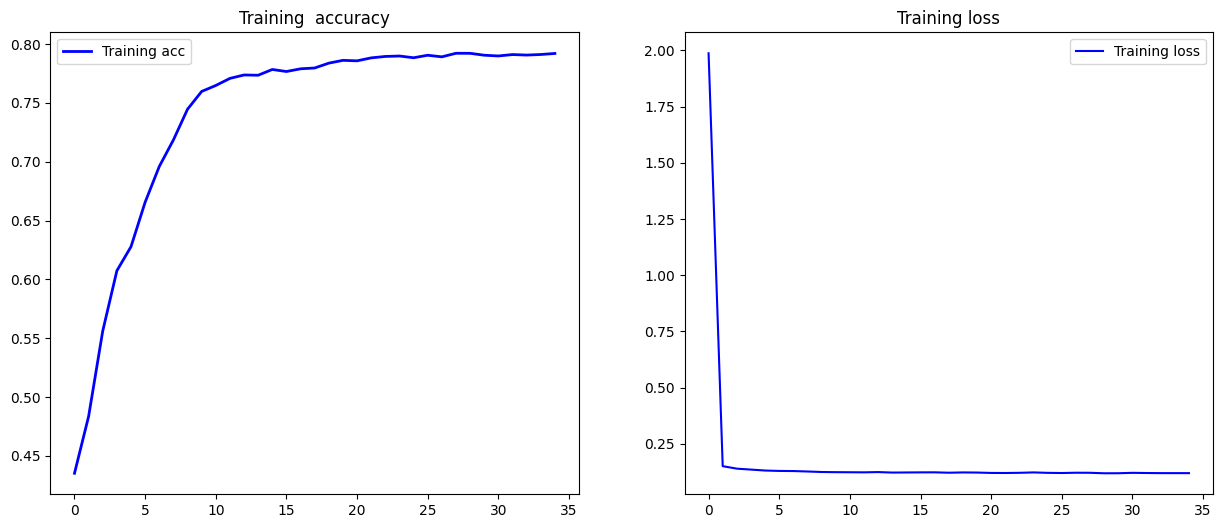

In [ ]:
plot_training_history(history_lstm_ada)

In [ ]:
np.mean(history_lstm_ada.history['accuracy'])

0.7403434157371521

In [ ]:
from keras.models import model_from_json

model_lstm_ada_json = model3.to_json()

with open("model_lstm_ada.json", "w") as json_file:
    json_file.write(model_lstm_ada_json)

model3.save_weights("model_lstm_ada.h5")
print("Model saved")

Model saved


In [ ]:
gen_data = val_generator_test_LSTM(X_test,Y_test)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model3.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.6614


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 2))
y_test=np.zeros((num_test, 2))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model3.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
roc_auc: 0.5078467133360598


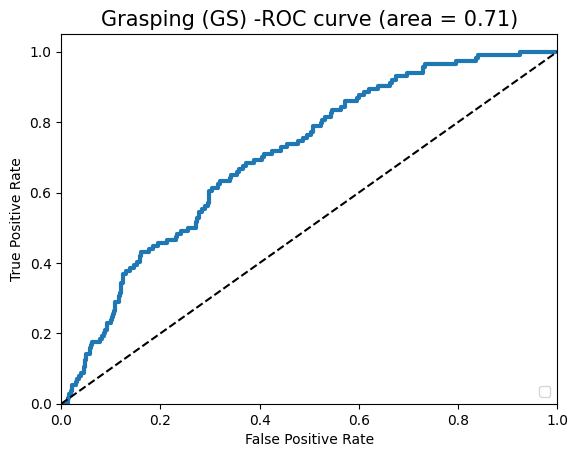

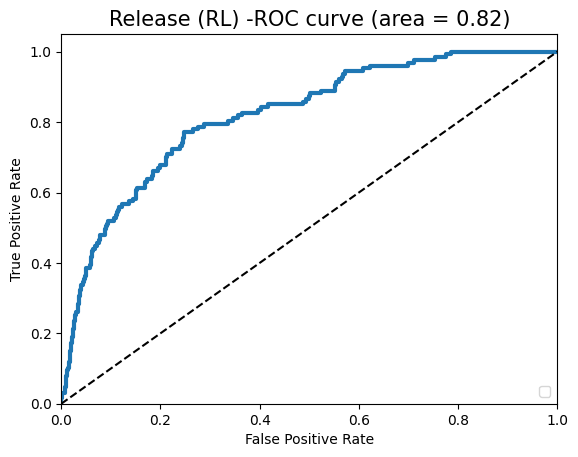

In [ ]:
l=["Grasping (GS)","Release (RL)"]
for i in range(0,2):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

#### Filtered Data

In [ ]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]
history = model3.fit(generator_LSTM(128, X_train, Y_train), steps_per_epoch = 2500, epochs=100,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/100
2500/2500 [==============================] - 43s 16ms/step - loss: 16.0250 - accuracy: 0.6667 - lr: 0.1000
Epoch 2/100
2500/2500 [==============================] - 39s 16ms/step - loss: 9.4736 - accuracy: 0.7140 - lr: 0.0999
Epoch 3/100
2500/2500 [==============================] - 39s 16ms/step - loss: 5.1946 - accuracy: 0.6938 - lr: 0.0998
Epoch 4/100
2500/2500 [==============================] - 40s 16ms/step - loss: 2.4709 - accuracy: 0.6752 - lr: 0.0997
Epoch 5/100
2500/2500 [==============================] - 39s 16ms/step - loss: 0.9066 - accuracy: 0.6624 - lr: 0.0996
Epoch 6/100
2500/2500 [==============================] - 39s 16ms/step - loss: 0.2418 - accuracy: 0.6488 - lr: 0.0995
Epoch 7/100
2500/2500 [==============================] - 39s 16ms/step - loss: 0.1373 - accuracy: 0.6635 - lr: 0.0994
Epoch 8/100
2500/2500 [==============================] - 39s 16ms/step - loss: 0.1340 - accuracy: 0.6818 - lr: 0.0993
Epoch 9/100
2500/2500 [==============================] 

In [ ]:
import time
import numpy as np
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

start=time.time()
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]
history2 = model2.fit(generator_LSTM(128, X_train, Y_train), steps_per_epoch = 2500, epochs=30,
                                    callbacks=callbacks_list)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/30
2500/2500 [==============================] - 182s 72ms/step - loss: 1.6505 - accuracy: 0.5698 - lr: 0.1000
Epoch 2/30
 485/2500 [====>.........................] - ETA: 2:24 - loss: 0.1310 - accuracy: 0.5656

KeyboardInterrupt: ignored

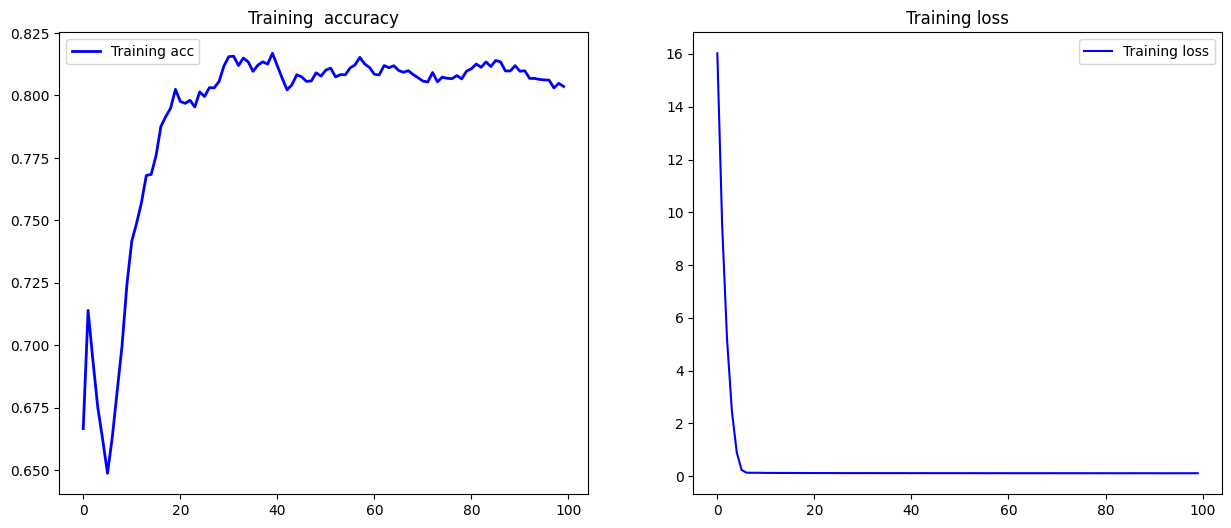

In [ ]:
plot_training_history(history)

In [ ]:
np.mean(history.history['accuracy'])

0.7924256253242493

In [ ]:
from keras.models import model_from_json

model_json = model3.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model3.save_weights("model.h5")
print("Model saved")

Model saved


##### Testing

In [ ]:
gen_data = val_generator_test_LSTM(X_test,Y_test)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data)
    score=model3.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.6962


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 2))
y_test=np.zeros((num_test, 2))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data)
    y_score[i,:]= model3.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
roc_auc: 0.4776594248432536


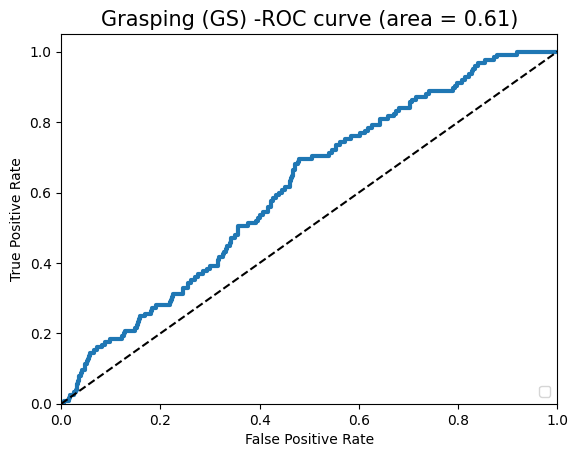

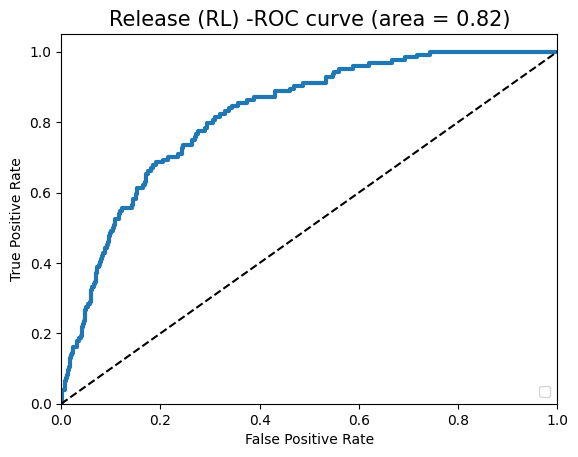

In [ ]:
l=["Grasping (GS)","Release (RL)"]
for i in range(0,2):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

#### Model with PCA

In [ ]:
import time
import numpy as np
#filtered data
start=time.time()
es_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience = 3)
history_pca =model.fit(generator(32, X_train_pca, Y_train_pca), steps_per_epoch=600, epochs = 50, callbacks=[es_callback])
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 0.1256 - accuracy: 0.3291 - mse: 0.1269
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1088 - accuracy: 0.4560 - mse: 0.1439
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1066 - accuracy: 0.5408 - mse: 0.1511
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1071 - accuracy: 0.5333 - mse: 0.1529
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1042 - accuracy: 0.5389 - mse: 0.1573
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1093 - accuracy: 0.5535 - mse: 0.1564
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1006 - accuracy: 0.5541 - mse: 0.1598
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1036 - accuracy: 0.4952 - mse: 0.1547
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 0.1031 - accur

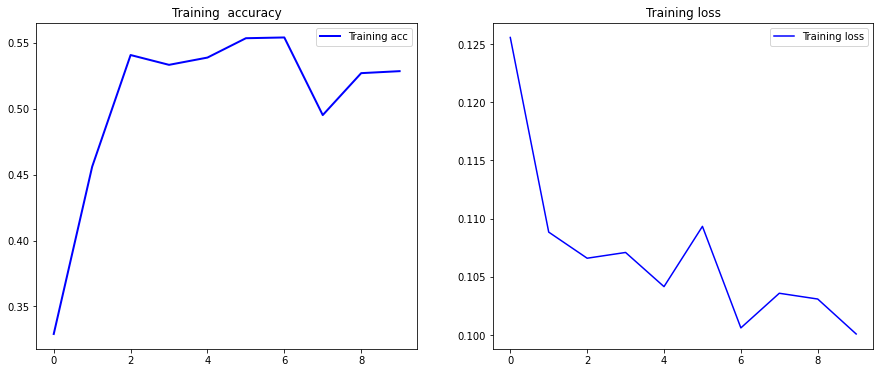

In [ ]:
plot_training_history(history_pca)

In [ ]:
np.mean(history_pca.history['accuracy'])

0.5056510448455811

##### Testing

In [ ]:
gen_data_pca = val_generator_test(X_test_pca,Y_test_pca)
scores_pca = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data_pca)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data_pca)
    score=model.evaluate(x_test, y_test, verbose=0)

    scores_pca.append(score[1])
scores_pca = np.asarray(scores_pca)

print("Accuracy ", np.mean(scores_pca))

Accuracy  0.5004


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 3))
y_test=np.zeros((num_test, 3))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data_pca)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data_pca)
    y_score[i,:]= model.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
roc_auc: 0.6314186071892418


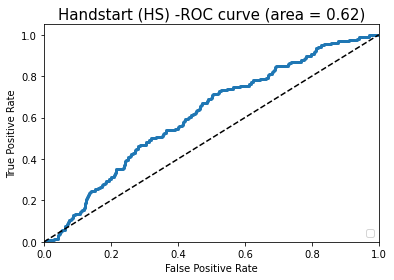

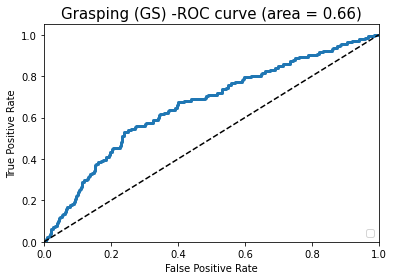

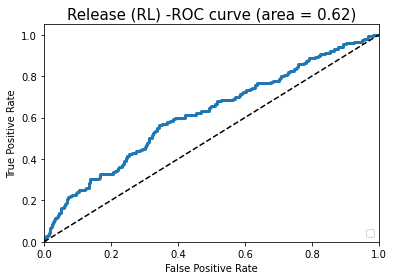

In [ ]:
l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
for i in range(0,3):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

#### Model with PCA_ICA

In [ ]:
import time
import numpy as np
#filtered data
start=time.time()
es_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience = 3)
history_pca =model.fit(generator(32, X_train_ica, Y_train_ica), steps_per_epoch=300, epochs = 50, callbacks=[es_callback])
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/50
300/300 [==============================] - 2s 5ms/step - loss: 0.1657 - accuracy: 0.2723 - mse: 0.1213
Epoch 2/50
300/300 [==============================] - 1s 5ms/step - loss: 0.1239 - accuracy: 0.4045 - mse: 0.1212
Epoch 3/50
300/300 [==============================] - 1s 5ms/step - loss: 0.1175 - accuracy: 0.5193 - mse: 0.1214
Epoch 4/50
300/300 [==============================] - 1s 5ms/step - loss: 0.1163 - accuracy: 0.4843 - mse: 0.1221
Epoch 5/50
300/300 [==============================] - 1s 5ms/step - loss: 0.1157 - accuracy: 0.2736 - mse: 0.1215
Epoch 6/50
300/300 [==============================] - 1s 5ms/step - loss: 0.1159 - accuracy: 0.2628 - mse: 0.1218
training time taken:  10.0 seconds


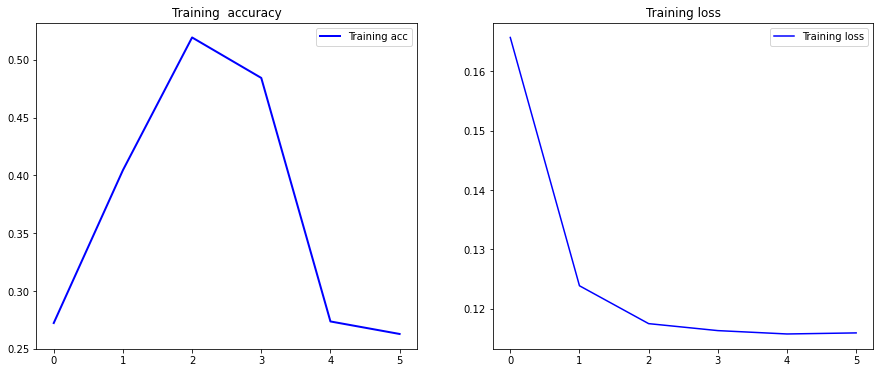

In [ ]:
plot_training_history(history_pca)

In [ ]:
np.mean(history_pca.history['accuracy'])

0.5056510448455811

##### Testing

In [ ]:
gen_data_pca = val_generator_test(X_test_pca,Y_test_pca)
scores_pca = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data_pca)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data_pca)
    score=model.evaluate(x_test, y_test, verbose=0)

    scores_pca.append(score[1])
scores_pca = np.asarray(scores_pca)

print("Accuracy ", np.mean(scores_pca))

Accuracy  0.5004


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 3))
y_test=np.zeros((num_test, 3))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data_pca)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data_pca)
    y_score[i,:]= model.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
roc_auc: 0.6314186071892418


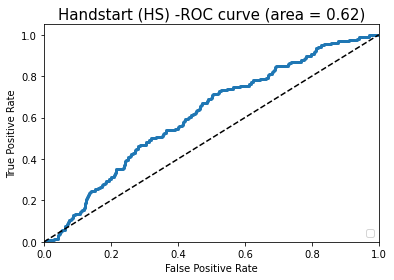

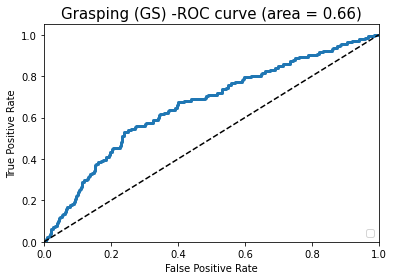

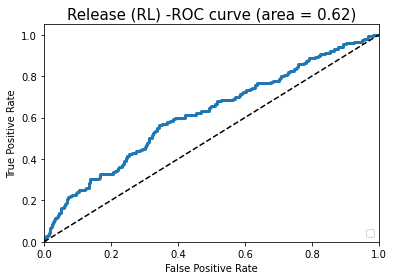

In [ ]:
l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
for i in range(0,3):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

### Model with LSTM

In [ ]:
time_steps = 1000
subsample = 10
model3 = Sequential()
model3.add(LSTM(64,input_shape = (time_steps//subsample, 32), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape = (time_steps//subsample, 32), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape = (time_steps//subsample, 32), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64))
model3.add(Dense(3, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0001), metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           24832     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)               

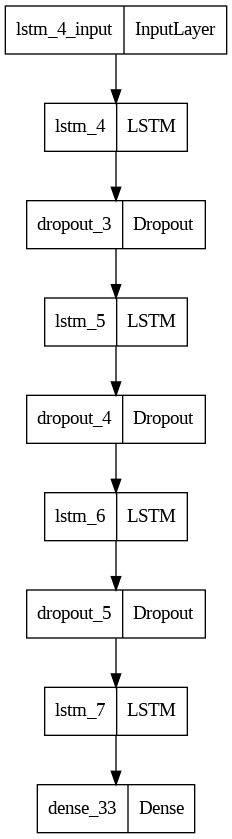

In [ ]:
from keras.utils import plot_model
plot_model(model3, to_file='model3.png')

In [ ]:
def generator_LSTM(batch_size, X_train, Y_train):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(X_train)-time_steps)
            x_time_data[i] = X_train[random_index:random_index+time_steps:subsample]
            yy.append(Y_train[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

In [ ]:
time_steps = 1000
subsample = 10
def val_generator_test_LSTM(test_x, test_y):
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(test_x)-time_steps)
            x_time_data[i] = test_x[random_index:random_index+time_steps:subsample]
            yy.append(test_y[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

#### Filtered Data

In [ ]:
import time
import numpy as np
#filtered data
start=time.time()
es_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience = 3)
history3 =model3.fit(generator_LSTM(32, X_train, Y_train), steps_per_epoch=600, epochs = 50, callbacks=[es_callback])
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/50
600/600 [==============================] - 20s 20ms/step - loss: 0.1632 - accuracy: 0.4740
Epoch 2/50
600/600 [==============================] - 14s 24ms/step - loss: 0.1116 - accuracy: 0.5592
Epoch 3/50
600/600 [==============================] - 11s 18ms/step - loss: 0.1069 - accuracy: 0.6172
Epoch 4/50
600/600 [==============================] - 11s 18ms/step - loss: 0.1086 - accuracy: 0.6257
Epoch 5/50
600/600 [==============================] - 11s 19ms/step - loss: 0.1054 - accuracy: 0.6026
Epoch 6/50
600/600 [==============================] - 11s 18ms/step - loss: 0.1073 - accuracy: 0.6585
Epoch 7/50
600/600 [==============================] - 11s 18ms/step - loss: 0.1070 - accuracy: 0.6506
Epoch 8/50
600/600 [==============================] - 11s 18ms/step - loss: 0.1018 - accuracy: 0.6475
Epoch 9/50
600/600 [==============================] - 11s 18ms/step - loss: 0.1042 - accuracy: 0.6890
Epoch 10/50
600/600 [==============================] - 11s 18ms/step - loss: 0.099

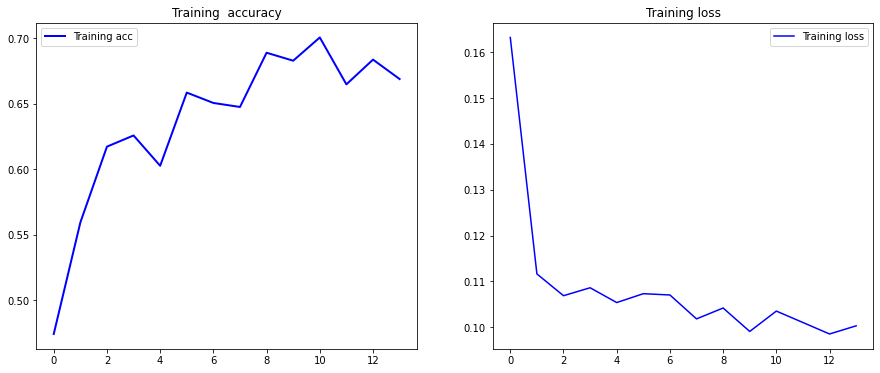

In [ ]:
plot_training_history(history3)

In [ ]:
np.mean(history3.history['accuracy'])

0.6375037176268441

##### Testing

In [ ]:
gen_data3 = val_generator_test_LSTM(X_Valid,Y_Valid)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data3)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data3)
    score=model3.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.5204


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 3))
y_test=np.zeros((num_test, 3))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data3)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data3)
    y_score[i,:]= model3.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 50ms/step
roc_auc: 0.6903865244587329


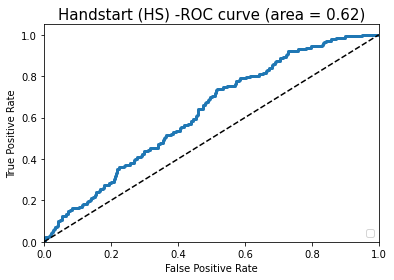

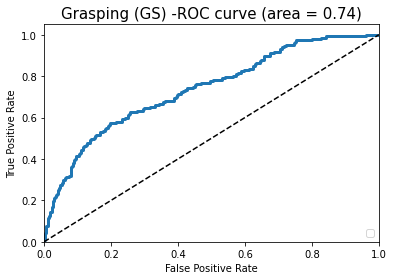

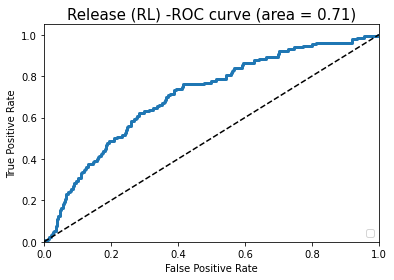

In [ ]:
l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
for i in range(0,3):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()


#### PCA Data

In [ ]:
import time
import numpy as np
#filtered data
start=time.time()
es_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience = 3)
history3 =model3.fit(generator_LSTM(32, X_train_pca, Y_train_pca), steps_per_epoch=600, epochs = 50, callbacks=[es_callback])
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/50
600/600 [==============================] - 22s 16ms/step - loss: 0.1668 - accuracy: 0.2494
Epoch 2/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1170 - accuracy: 0.3889
Epoch 3/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1107 - accuracy: 0.5807
Epoch 4/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1112 - accuracy: 0.6214
Epoch 5/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1081 - accuracy: 0.6881
Epoch 6/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1059 - accuracy: 0.6553
Epoch 7/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1059 - accuracy: 0.6426
Epoch 8/50
600/600 [==============================] - 10s 16ms/step - loss: 0.1048 - accuracy: 0.6950
Epoch 9/50
600/600 [==============================] - 13s 22ms/step - loss: 0.1009 - accuracy: 0.7118
Epoch 10/50
600/600 [==============================] - 10s 16ms/step - loss: 0.102

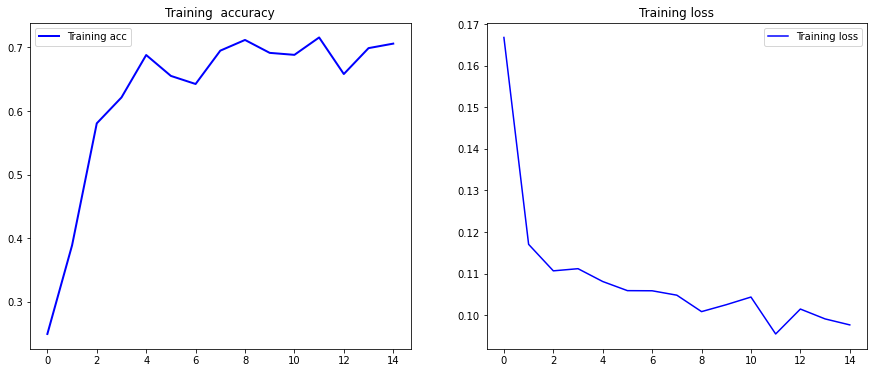

In [ ]:
plot_training_history(history3)

In [ ]:
np.mean(history3.history['accuracy'])

0.6261319537957509

##### Testing

In [ ]:
gen_data3_pca = val_generator_test_LSTM(X_test_pca,Y_test_pca)
scores = []
num_test =5000
for i in range(num_test):
    x_test, y_test = next(gen_data3_pca)
   # print(y_test)
    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test = next(gen_data3_pca)
    score=model3.evaluate(x_test, y_test, verbose=0)

    scores.append(score[1])
scores = np.asarray(scores)

print("Accuracy ", np.mean(scores))

Accuracy  0.5128


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
num_test = 5000
y_score=np.zeros((num_test, 3))
y_test=np.zeros((num_test, 3))

for i in range(num_test):
    x_test, y_test[i,:] = next(gen_data3_pca)

    while not 1 in y_test:
     #   print(x_test)
        x_test, y_test[i,:]  = next(gen_data3_pca)
    y_score[i,:]= model3.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



print("roc_auc:",sum(roc_auc.values())/3)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
roc_auc: 0.6700894552658768


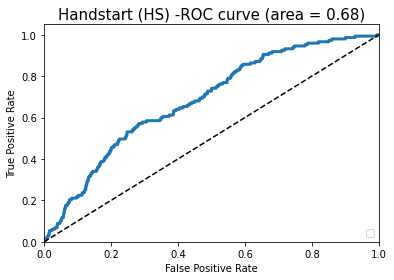

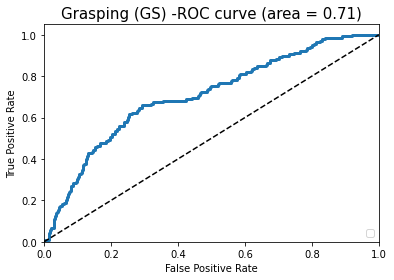

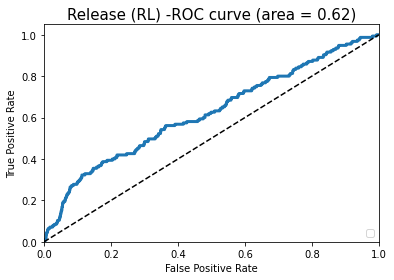

In [ ]:
l=["Handstart (HS)","Grasping (GS)","Release (RL)"]
for i in range(0,3):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

## Using MNE

In [ ]:
import numpy as np
import pandas as pd
from mne.io import RawArray
# from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
# from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# from sklearn.cross_validation import cross_val_score, LeaveOneLabelOut
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types

In [ ]:
from mne import create_info, concatenate_raws, pick_types
def create_mne_raw_object(fname, read_events=True):
    """Create a mne raw instance from csv file."""
    # Read EEG file
    data = pd.read_csv(fname)

    # get chanel names
    ch_names = list(data.columns[1:])


    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T

    if read_events:
        # events file
        ev_fname = fname.replace('_data', '_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T

        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data, events_data))

    # create and populate MNE info structure
    info = create_info(ch_names, sfreq=500.0, ch_types=ch_type)
    info['temp'] = fname

    # create raw object
    raw = RawArray(data, info, verbose=False)

    return raw


In [ ]:
def load_raw_data(subject, test=False):
    """Load Raw data from files.
    For a given subject, csv files are loaded, converted to MNE raw instance
    and concatenated.
    If test is True, training data are composed of series 1 to 8 and test data
    of series 9 and test. Otherwise, training data are series 1 to 6 and test
    data series 7 and 8.
    """
    fnames_train = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    if test:
        fnames_test = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    else:
        fnames_test = fnames_train[-2:]
        fnames_train = fnames_train[:-2]

    # read and concatenate all the files
    raw_train = [create_mne_raw_object(fname) for fname in fnames_train]
    raw_train = concatenate_raws(raw_train)
    # pick eeg signal
    picks = pick_types(raw_train.info, eeg=True)

    # get training data
    data_train = raw_train._data[picks].T
    labels_train = raw_train._data[32:].T

    raw_test = [create_mne_raw_object(fname, read_events=not test) for fname in
                fnames_test]
    raw_test = concatenate_raws(raw_test)
    data_test = raw_test._data[picks].T

    # extract labels if validating on series 7&8
    labels_test = None
    if not test:
        labels_test = raw_test._data[32:].T

    return raw_train, data_train, labels_train, data_test, labels_test


In [ ]:
raw, data_train, labels_train, data_test, labels_test = load_raw_data(3)

In [ ]:
raw

<RawArray | 38 x 1105800 (2211.6 s), ~320.6 MB, data loaded>

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


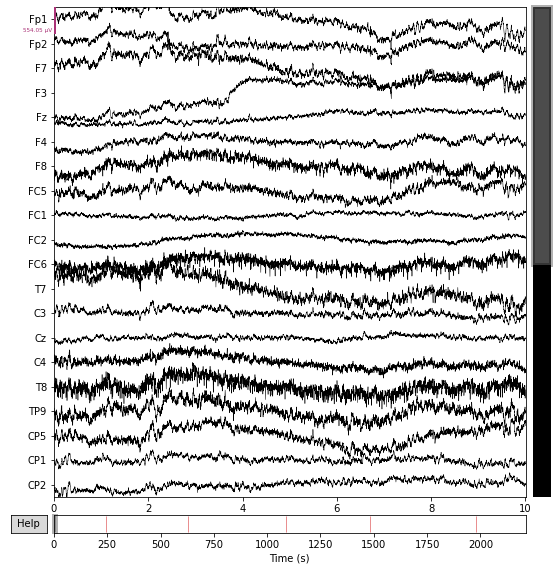

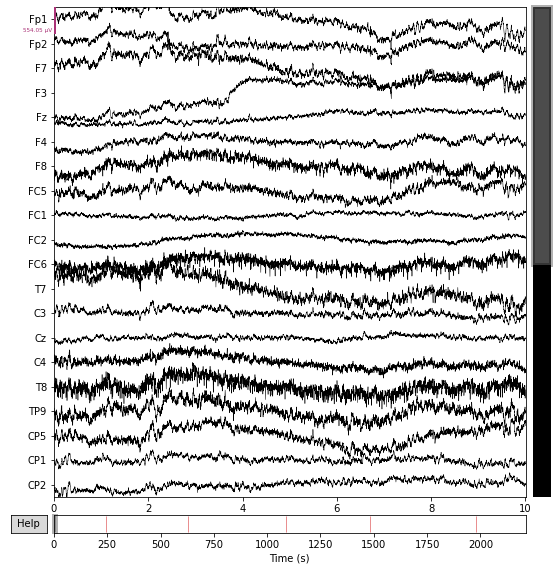

In [ ]:
raw.plot(scalings='auto')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<ipython-input-116-a5fcf744740b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


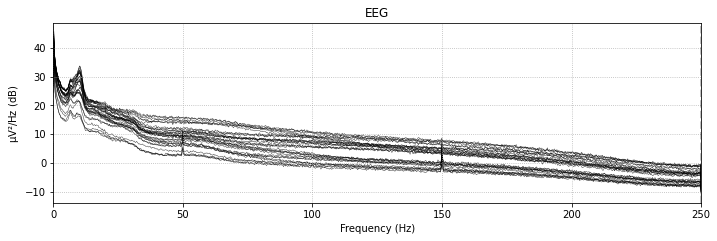

In [ ]:
raw.plot_psd()

In [ ]:
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2',
            'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2',
            'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz',
            'O2', 'PO10']

In [ ]:
events_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
            'Replace', 'BothReleased']


In [ ]:
events = list()
events_id = dict()
for j, eid in enumerate(events_names):
      tmp = find_events(raw, stim_channel=eid, verbose=False)
      tmp[:, -1] = j + 1
      events.append(tmp)
      events_id[eid] = j + 1

In [ ]:
events

array([   1163,       0,       1, ..., 1104518,       0,       6])

In [ ]:
events = np.concatenate(events, axis=0)
order_ev = np.argsort(events[:, 0])
events = events[order_ev]
picks = pick_types(raw.info,eeg=True)


epochs = Epochs(raw, events, events_id,
                tmin=-(500 / 500.0) + 1 / 500.0 + 0.150,
                tmax=0.150, proj=False, baseline=None,
                preload=True, verbose=False)

In [ ]:
epochs

<Epochs |  1152 events (all good), -0.848 - 0.15 sec, baseline off, ~167.0 MB, data loaded,
 'HandStart': 192
 'FirstDigitTouch': 192
 'BothStartLoadPhase': 192
 'LiftOff': 192
 'Replace': 192
 'BothReleased': 192>

In [ ]:
epochs_train = epochs.copy().crop(tmin=0.1, tmax=0.14)
labels = epochs.events[:, -1] - 2

In [ ]:
labels

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# # plot CSP patterns estimated on full data for visualization
# csp.fit_transform(epochs_data, labels)

# csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.47 (2.2e-16 eps * 38 dim * 5.6e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.65 (2.2e-16 eps * 38 dim * 7.7e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.7 (2.2e-16 eps * 38 dim * 8.3e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimat

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.47 (2.2e-16 eps * 38 dim * 5.5e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.65 (2.2e-16 eps * 38 dim * 7.7e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.68 (2.2e-16 eps * 38 dim * 8.1e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estima

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.49 (2.2e-16 eps * 38 dim * 5.8e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.64 (2.2e-16 eps * 38 dim * 7.6e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.68 (2.2e-16 eps * 38 dim * 8.1e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estima

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.48 (2.2e-16 eps * 38 dim * 5.7e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.65 (2.2e-16 eps * 38 dim * 7.7e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.7 (2.2e-16 eps * 38 dim * 8.3e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimat

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.48 (2.2e-16 eps * 38 dim * 5.7e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.64 (2.2e-16 eps * 38 dim * 7.6e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.69 (2.2e-16 eps * 38 dim * 8.2e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estima

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.48 (2.2e-16 eps * 38 dim * 5.7e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.65 (2.2e-16 eps * 38 dim * 7.7e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.7 (2.2e-16 eps * 38 dim * 8.3e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimat

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.49 (2.2e-16 eps * 38 dim * 5.9e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.64 (2.2e-16 eps * 38 dim * 7.6e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.71 (2.2e-16 eps * 38 dim * 8.4e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estima

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.47 (2.2e-16 eps * 38 dim * 5.5e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.65 (2.2e-16 eps * 38 dim * 7.7e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.7 (2.2e-16 eps * 38 dim * 8.2e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimat

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.48 (2.2e-16 eps * 38 dim * 5.7e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.63 (2.2e-16 eps * 38 dim * 7.5e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.71 (2.2e-16 eps * 38 dim * 8.4e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estima

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Computing rank from data with rank=None
    Using tolerance 0.49 (2.2e-16 eps * 38 dim * 5.8e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.62 (2.2e-16 eps * 38 dim * 7.4e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.71 (2.2e-16 eps * 38 dim * 8.4e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estima

/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:612: RuntimeWarning: invalid value encountered in true_divide
  g12 = np.mean(A[ii, Ij] / c1)
/usr/local/lib/python3.8/dist-packages/mne/decoding/csp.py:616: RuntimeWarning: divide by zero encountered in true_divide
  omega12 = np.mean(c2 / c1)


Classification accuracy: nan / Chance level: 0.833333


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.8/dist-packages

In [ ]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

Computing rank from data with rank=None
    Using tolerance 0.47 (2.2e-16 eps * 38 dim * 5.6e+13  max singular value)
    Estimated rank (mag): 33
    MAG: rank 33 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 33
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.65 (2.2e-16 eps * 38 dim * 7.7e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.7 (2.2e-16 eps * 38 dim * 8.3e+13  max singular value)
    Estimated rank (mag): 35
    MAG: rank 35 computed from 38 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 38 -> 35
Estimat

LinAlgError: ignored

In [ ]:
import mne
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=500)
    data=mne.io.RawArray(sub.T, info)
    # data.set_eeg_reference()
    #data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=3,overlap=2)
    return epochs.get_data(), data

In [ ]:
test, raw = convertDF2MNE(pd.concat(raw))
test.shape

Creating RawArray with float64 data, n_channels=32, n_times=4469711
    Range : 0 ... 4469710 =      0.000 ...  8939.420 secs
Ready.
Not setting metadata
8937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8937 events and 1500 original time points ...
0 bad epochs dropped


(8937, 32, 1500)

In [ ]:
events_tot = list(pd.concat(y_raw).columns)

In [ ]:
events_tot

['HandStart',
 'FirstDigitTouch',
 'BothStartLoadPhase',
 'LiftOff',
 'Replace',
 'BothReleased']

In [ ]:
later_annot = mne.Annotations(onset=[3, 5, 7, 9, 11, 13],
                              duration=[2, 2.5, 2.25, 1, 0.5, 0.25],
                              description=events_names)

raw2 = raw.copy().set_annotations(later_annot)


ValueError: ignored

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(picks)
print(event_dict)
print(events_from_annot)

AttributeError: ignored

In [ ]:
epochs = mne.Epochs(raw, events, event_id=[1,2,3,4,5,6],tmin= -0.1, tmax=0.7, preload=True)

ValueError: ignored

In [ ]:
epochs.get_data().shape

(6, 32, 401)

In [ ]:
labels = epochs.events[:, -1]
len(labels)

6

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


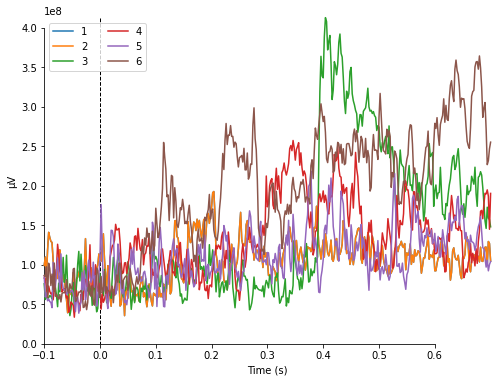

[<Figure size 576x432 with 1 Axes>]

In [ ]:
evoked_1 = epochs['1'].average()
evoked_2 = epochs['2'].average()
evoked_3 = epochs['3'].average()
evoked_4 = epochs['4'].average()
evoked_5 = epochs['5'].average()
evoked_6 = epochs['6'].average()
dicts ={'1':evoked_1,'2':evoked_1, '3':evoked_3,'4':evoked_4, '5':evoked_5,'6':evoked_6}
mne.viz.plot_compare_evokeds(dicts)

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


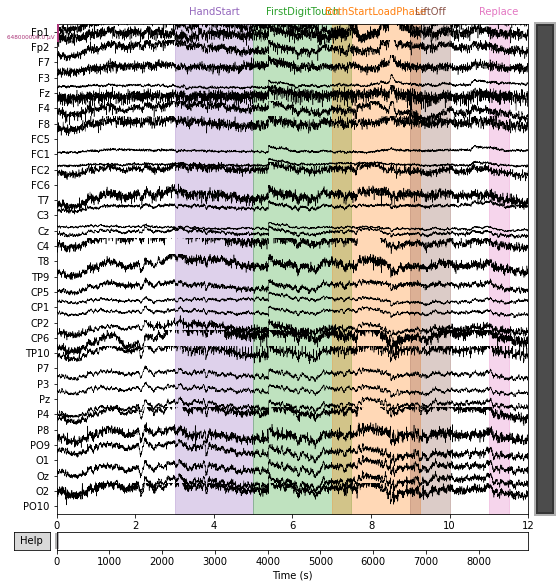

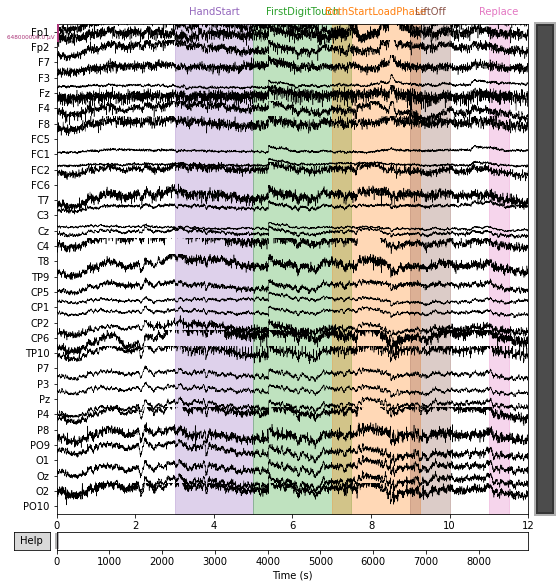

In [ ]:
raw2.plot(duration=12, proj=False, n_channels=len(raw2.ch_names),
         remove_dc=False, scalings='auto')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<ipython-input-51-a83771a363d9>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw2.plot_psd()


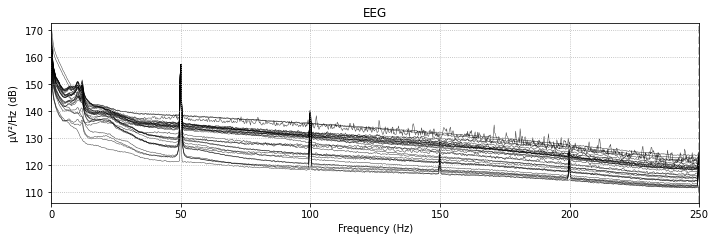

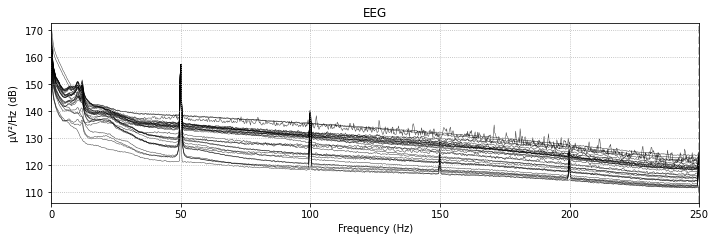

In [ ]:
raw2.plot_psd()

In [ ]:
epochs_train = epochs.copy().crop(tmin=0.2, tmax=0.6)
labels = epochs.events[:, -1] - 2

### Pre-processing

#### Signal Denoising

In [ ]:
from skimage.restoration import denoise_wavelet
import pywt
def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [ ]:
filtered = wavelet_denoising(epochs.get_data(), wavelet='db2', level=3)

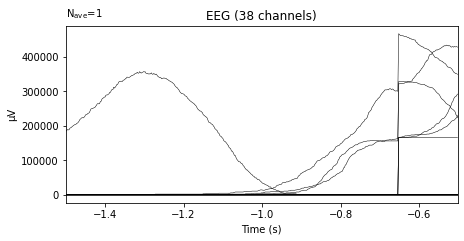

In [ ]:
ev_fil = mne.EvokedArray(np.mean(filtered, axis=0),
                     mne.create_info(38, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=-1.5)
ev_fil.plot(show=False, window_title="Denoising", time_unit='s')

### Feature Extraction

#### PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

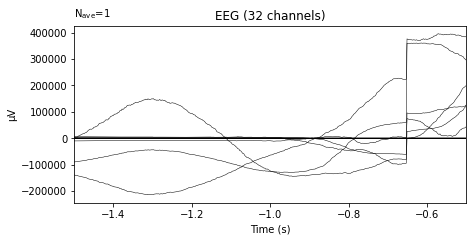

In [ ]:
pca = UnsupervisedSpatialFilter(PCA(32), average=False)
pca_data = pca.fit_transform(epochs.get_data())
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(32, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=-1.5)
ev.plot(show=False, window_title="PCA", time_unit='s')

#### ICA (Independent Component Analysis)

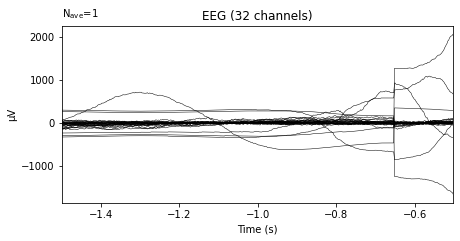

In [ ]:
ica = UnsupervisedSpatialFilter(
    FastICA(32, whiten='unit-variance'), average=False)
ica_data = ica.fit_transform(pca_data)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(32, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=-1.5)
ev1.plot(show=False, window_title='ICA', time_unit='s')

### Split Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
filtered.shape

(6, 32, 402)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(np.array(filtered), ch_names, test_size=0.1, random_state=42)

ValueError: ignored

In [ ]:
X_train, X_Valid, Y_train, Y_Valid = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [ ]:
print('Number of examples in each set:')
print(f'Training: {len(X_train)}')
print(f'Validation: {len(X_Valid)}')
print(f'Test: {len(test_x)}')

Number of examples in each set:
Training: 2538447
Validation: 282050
Test: 313389


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


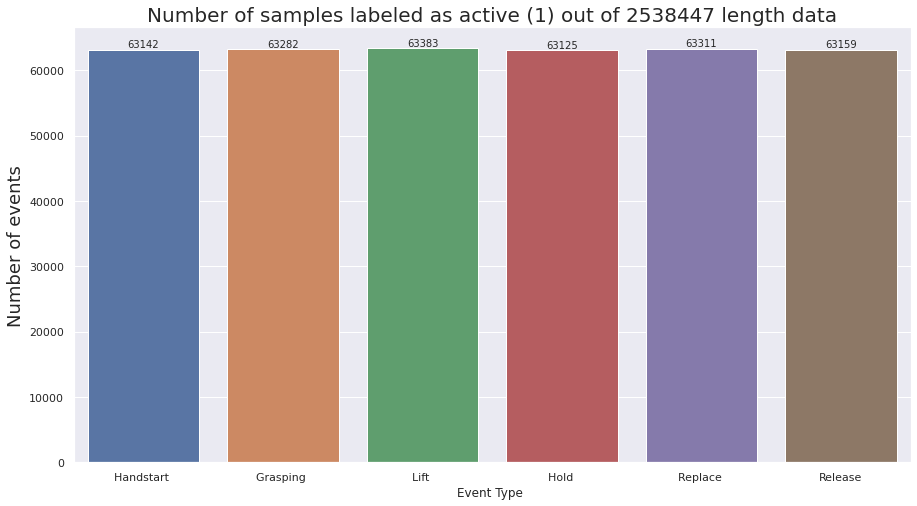

In [ ]:
import seaborn as sns
ye=pd.DataFrame(Y_train)

ye.columns=["Handstart ","Grasping ","Lift ","Hold ","Replace ","Release"]
categories = list(ye.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, ye.iloc[:,0:].sum().values)
plt.title("Number of samples labeled as active (1) out of {0} length data".format((ye.shape[0])),fontsize=20)

plt.ylabel('Number of events', fontsize=18)
plt.xlabel('Event Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = ye.iloc[:,0:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

In [ ]:
X_train.shape

(2538447, 32)

In [ ]:
Y_train.shape

(5986677, 6)

In [ ]:
X_train

Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz  \
88916   195  188  392  611  -18  388   32  584   -3   67  ...  517  158  303   
54173  -120  -75   76   50  402  566 -235  465  281   33  ...  489  271  487   
261645  614  588  484   94  -64  478  411  579  307  332  ...  422  247  456   
75707   -44  355  257  113   20  487   70  215   28  127  ...  225   61  180   
50187   -26  660  571  232  390  411  268  444   96   42  ...  405  299   98   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
185941   32  273  713  280  -29  106  216  292   87  150  ...  254  292  202   
95262   197  158  434  237 -154  253  400  407   48  134  ...   58   15   17   
118434  277  383  493   -7  529  767  246 -161 -114   13  ... -171   59  244   
206378 -216 -294  437  -86   92  131  -87  311  135  -17  ...  -56  273  153   
69027   343  -29 -278  -60  -84  115  -64  218 -291 -500  ...  149  451  195   

         P4   P8  PO9   O1   Oz   O2  PO10  
88916   189  342  401  440  557  448   360  
54173   559  349  254   94  408  129   147  
261645  141  480  362  204  170  155   130  
75707   125  347 -135  123    6 -107   221  
50187   204  271   -3  380  130   16   -90  
...     ...  ...  ...  ...  ...  ...   ...  
185941  436  518  146  249  256  234   223  
95262   175  119 -128 -111   81 -110  -240  
118434  187  -76 -660  -96 -230  -84   -74  
206378  423  237 -180  130  -98 -100   -65  
69027  -132  444  -72  304  510   93   285  

[5986677 rows x 32 columns]

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import torch.nn.functional as F

class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(self.label[index])
  def __len__(self):
    return len(self.feat_arr)

train_dataloader = DataLoader(dataset(X_train, Y_train),batch_size = 128, shuffle=True)
val_dataloader = DataLoader(dataset(X_Valid, Y_Valid),batch_size = 128, shuffle=True)
test_dataloader = DataLoader(dataset(test_x,test_x),batch_size = 128, shuffle=True)

### Model

In [ ]:
print(labels)

[ 2  1  0  3  4 -1]


In [ ]:
epochs_train

<Epochs |  6 events (all good), 0.2 - 0.6 sec, baseline -0.1 – 0 sec (baseline period was cropped after baseline correction), ~336 kB, data loaded,
 '1': 1
 '2': 1
 '3': 1
 '4': 1
 '5': 1
 '6': 1>

In [ ]:
print(np.unique(labels))

[-1  0  1  2  3  4]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, np.unique(labels), cv=cv, n_jobs=8)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

Classification accuracy: nan / Chance level: 0.833333
Computing rank from data with rank=None
    Using tolerance 61 (2.2e-16 eps * 32 dim * 8.6e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 32 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+02 (2.2e-16 eps * 32 dim * 1.8e+16  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 98 (2.2e-16 eps *

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py", line 552, in fit
    raise ValueError(
ValueError: The number of samples must be more tha

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 32 dim * 2.2e+16  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.


array([[-2.5881846 , -0.28969101,  0.8841803 , -0.26658073, -0.57726509,
         0.32343355, -0.5806648 , -0.07823345, -0.16087961, -0.4229313 ],
       [ 1.06081622, -0.29588105, -0.40716023, -0.59140013,  0.01258334,
         0.35974533, -0.12773219, -0.73891385,  0.19750282, -0.16657313],
       [-2.61653512, -0.91760484, -0.40376915,  0.81813653, -0.12272175,
        -0.1313899 , -0.11935519,  0.94589055, -0.25766293, -0.01948188],
       [-3.04409461,  0.61858998, -0.69517738, -0.29444396, -0.52567831,
        -1.03207883,  0.9366689 , -0.38437416, -0.84247636,  0.50600352],
       [ 1.04833693,  0.40176577, -0.50265404,  0.08448537, -0.40875669,
         0.05765582, -0.62416532, -0.30654301,  0.49465909,  0.24859202],
       [-3.04585526, -0.2978375 ,  0.11937603, -0.568956  ,  0.8201335 ,
        -0.13043114, -0.5607985 , -0.52646837,  0.06938501, -0.57664813]])

In [ ]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

Computing rank from data with rank=None
    Using tolerance 58 (2.2e-16 eps * 32 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 36 (2.2e-16 eps * 32 dim * 5e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 57 (2.2e-16 eps * 32 dim * 8e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 50 (2.2e-16 eps * 32 dim * 7e+15  max singular value)
    Estimated rank (mag): 

ValueError: ignored

In [ ]:
import time
start=time.time()
def generator(batch_size):
    while 1:

        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(X_train)-time_steps)
            x_time_data[i] = X_train[random_index:random_index+time_steps:subsample]
            yy.append(Y_train[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1],  x_time_data.shape[2],1)), yy
history =model.fit_generator(generator(32), steps_per_epoch = 600, epochs = 50,validation_data=valgenerator(),
                              validation_steps=200)
print('training time taken: ',round(time.time()-start,0),'seconds')

<ipython-input-50-1ec6618aff9b>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(generator(32), steps_per_epoch = 600, epochs = 50,validation_data=valgenerator(),


KeyError: ignored